<a href="https://colab.research.google.com/github/marc-queiroz/ml_lab3/blob/master/lab3_lenet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LABORATÓRIO 3 - LeNet-5


## Testando GPUs



In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
if (device_name):
  print('GPU device located: {}'.format(device_name))
  !nvidia-smi

GPU device located: /device:GPU:0
Sun Sep  6 04:17:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W /  70W |    227MiB / 15079MiB |      1%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                      

Caso a saída seja: `Found...` então, pode-se executar a próxia linha, que habilita a execução.

## IMPORTANDO OS DADOS DO GITHUB

In [2]:
!rm -rf ml_lab3/
!git clone https://github.com/marc-queiroz/ml_lab3 ml_lab3

Cloning into 'ml_lab3'...
remote: Enumerating objects: 20014, done.
remote: Counting objects: 100% (20014/20014), done.
remote: Compressing objects: 100% (20011/20011), done.
remote: Total 44270 (delta 5), reused 20011 (delta 3), pack-reused 24256
Receiving objects: 100% (44270/44270), 134.21 MiB | 36.67 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Checking out files: 100% (55127/55127), done.


## REALIZANDO OS IMPORTS

Aqui reliza-se as importações dos pacotes que serão utilizados nos experimentos.

In [53]:
import numpy as np
from numpy import expand_dims
import cv2
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import f1_score as sklearn_f1_score
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix

from PIL import Image

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, BatchNormalization
from keras.models import Model
from keras.regularizers import l2

from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

import os
import time
import glob
from tempfile import mkstemp
from shutil import move, copymode
from os import fdopen, remove

## DEFININDO AS ENTRADAS

Então, é necessário definir os arquivos de entrada obtidos através do GitHub.

In [4]:
TRAIN_FILE = "./ml_lab3/train.txt"
TEST_FILE = "./ml_lab3/test.txt"

## Funções para preparações de dados

In [85]:
def resize_data(data, size, convert):
	if convert:
		data_upscaled = np.zeros((data.shape[0], size[0], size[1], 3))
	else:
		data_upscaled = np.zeros((data.shape[0], size[0], size[1]))
	for i, img in enumerate(data):
		large_img = cv2.resize(img, dsize=(size[1], size[0]), interpolation=cv2.INTER_CUBIC)
		data_upscaled[i] = large_img
	return data_upscaled

def load_images(image_paths, convert=False):
	x = []
	y = []
	for image_path in image_paths:		
		path, label = image_path.split(' ')	  
		path= './ml_lab3/' + path
		if convert:
			image_pil = Image.open(path).convert('RGB') 
		else:
			image_pil = Image.open(path).convert('L')
		img = np.array(image_pil, dtype=np.uint8)
		x.append(img)
		y.append([int(label)])
	x = np.array(x)
	y = np.array(y)
	if np.min(y) != 0: 
		y = y-1
	return x, y

def load_dataset(train_file, test_file, resize, convert=False, size=(224,224)):
	arq = open(train_file, 'r')
	texto = arq.read()
	train_paths = texto.split('\n')
	print ('Size:', size)
	train_paths.remove('')
	train_paths.sort()
	print ("Loading training set...")
	x_train, y_train = load_images(train_paths, convert)
	arq = open(test_file, 'r')
	texto = arq.read()
	test_paths = texto.split('\n')
	test_paths.remove('')
	test_paths.sort()
	print ("Loading testing set...")
	x_test, y_test = load_images(test_paths, convert)
	if resize:
		print ("Resizing images...")
		x_train = resize_data(x_train, size, convert)
		x_test = resize_data(x_test, size, convert)
	if not convert:
		x_train = x_train.reshape(x_train.shape[0], size[0], size[1], 1)
		x_test = x_test.reshape(x_test.shape[0], size[0], size[1], 1)
	print (np.shape(x_train))
	return (x_train, y_train), (x_test, y_test)
 
def generate_labels(x_test, y_test):
  labels = []
  for i in range(len(x_test)):
    labels.append(y_test[i][0])
  return labels

def normalize_images(x):
  x = x.astype('float32')
  x /= 255
  return x

def convert_vector(x, num_classes):
  return keras.utils.to_categorical(x, num_classes)

def fit_model(model, x_train, y_train, x_test, y_test, epochs, batch_size=128, verbose=1, steps_per_epoch=None):
  return model.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=verbose, steps_per_epoch=steps_per_epoch)

def get_confusion_matrix(model, x_test, labels):
  pred = []
  y_pred = model.predict_classes(x_test)
  for i in range(len(x_test)):
    pred.append(y_pred[i])
  return confusion_matrix(labels, pred)

def plot_graphs(history, filename=None):
	acc = history.history['accuracy']
	val_acc = history.history['val_accuracy']
	loss = history.history['loss']
	val_loss = history.history['val_loss']
	epochs = range(len(acc))
	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
	ax1.plot(epochs, acc, 'b', label='Acurácia do treinamento')
	ax1.plot(epochs, val_acc, 'r', label='Acurácia da validação')
	ax1.set_title('Acurácia do treinamento e validação')
	ax1.legend()
	ax2.plot(epochs, loss, 'b', label='Perda do treinamento')
	ax2.plot(epochs, val_loss, 'r', label='Perda da validação')
	ax2.set_title('Perda do treinamento e validação')
	ax2.legend()
	if (filename):
		fig.savefig(filename)
		from google.colab import files
		files.download(filename)
	plt.show()

def extract_features(input_file, output_file, img_rows, img_cols, dir_dataset):
	file_input = open (input_file, 'r')
	input = file_input.readlines()
	file_input.close()
	output = open(output_file, 'w')
	model = InceptionV3(weights='imagenet', include_top=False)
	for i in input:
		sample_name, sample_class = i.split()
		img_path = dir_dataset + sample_name
		print(img_path)
		img = image.load_img(img_path, target_size=(img_rows,img_cols))
		img_data = image.img_to_array(img)
		img_data = np.expand_dims(img_data, axis=0)
		img_data = preprocess_input(img_data)
		inception_features = model.predict(img_data)
		features_np = np.array(inception_features)
		features_np = features_np.flatten()
		output.write(sample_class+' ')
		for j in range (features_np.size):
			output.write(str(j+1)+':'+str(features_np[j])+' ')
		output.write('\n')
	print(features_np.size)
	output.close()
 
def round_float(value):
	return float("{:.3f}".format(value))
 
def get_time():
    return time.time()

def get_time_diff(start_time):
    end_time = time.time()
    return round_float(end_time - start_time)

def plot_confusion_matrix(cm, filename):
	fig = plt.figure(figsize=(10,10))
	ax = fig.add_subplot(111)
	cax = ax.matshow(cm)
	for (x, y), value in np.ndenumerate(cm):
		plt.text(x, y, f"{value:.0f}", va="center", ha="center")
	plt.title('Matriz de Confusão')
	fig.colorbar(cax)
	plt.xlabel('Predicted')
	plt.ylabel('True')
	if (filename):
		fig.savefig(filename)
		from google.colab import files
		files.download(filename)
	plt.show()

print('DEFININDO AS FUNÇÕES AUXILIARES - DONE', datetime.now())


DEFININDO AS FUNÇÕES AUXILIARES - DONE 2020-09-06 05:41:39.538868


# DEFINIÇÃO DO MODELO


In [8]:
def lenet5(img_rows, img_cols, num_classes):
  model = Sequential()
  model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(img_rows,img_cols,3), padding="same"))
  model.add(AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'))
  model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
  model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
  model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
  model.add(Flatten())
  model.add(Dense(84, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  return model

## Se for criar outro modelo crie uma nova função e novos trechos de execução no Colab

print('DEFINIÇÃO DO MODELO - DONE')

DEFINIÇÃO DO MODELO - DONE


# LENET 5 - SEM DATA AUGMENTATION

## EXECUÇÃO

Size: (50, 50)
Loading training set...
Loading testing set...
Resizing images...
(1578, 50, 50, 3)
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_125 (Conv2D)          (None, 50, 50, 6)         456       
_________________________________________________________________
average_pooling2d_82 (Averag (None, 49, 49, 6)         0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 45, 45, 16)        2416      
_________________________________________________________________
average_pooling2d_83 (Averag (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 18, 18, 120)       48120     
_________________________________________________________________
flatten_42 (Flatten)         (None, 38880)             0         
____________________

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

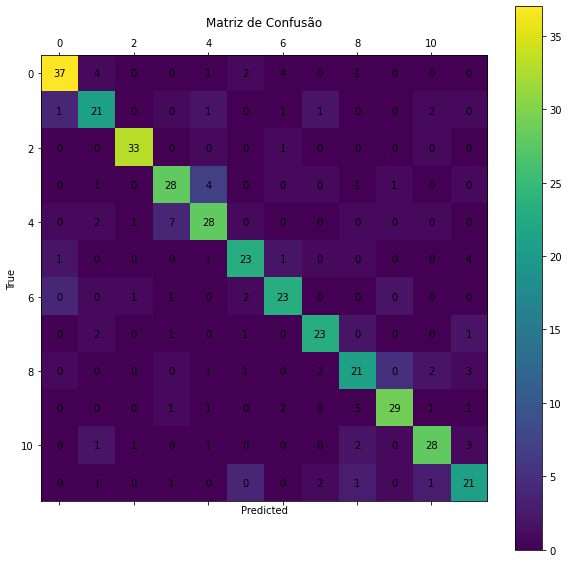

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

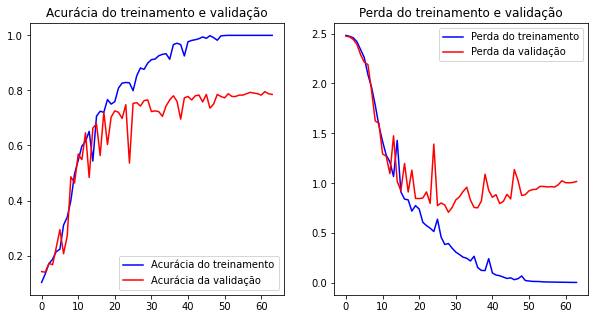

EXECUÇÃO - DONE


In [88]:
## Star Time
checkpoint_time = get_time()

## Definitions
NUM_CLASSES = 12
IMG_ROWS = 50
IMG_COLS = 50
EPOCHS = 64
BATCH_SIZE = 128

## Loading Inital Data
(x_train, y_train), (x_test, y_test) = load_dataset(TRAIN_FILE, TEST_FILE, resize=True, convert=True, size=(IMG_ROWS, IMG_COLS))

## Normalize images
x_train = normalize_images(x_train)
x_test = normalize_images(x_test)

## Generating Labels for Confusion Matrix
labels = generate_labels(x_test, y_test)

## Convert class vectros to binary class matrices
y_train = convert_vector(y_train, NUM_CLASSES)
y_test = convert_vector(y_test, NUM_CLASSES)

## Get LeNet 5 Model
model = lenet5(IMG_ROWS, IMG_COLS, NUM_CLASSES)

## Printing Summary
model.summary()

## Compiling Model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=["accuracy"])

## Trainning model
history = fit_model(model, x_train, y_train, x_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

## Getting Score
score = model.evaluate(x_test, y_test, verbose=0)

## Loss
print('Loss:', score[0])

## Accuracy
print('Accuracy:', score[1])

## Execution Time
print(f'Execution Time: {get_time_diff(checkpoint_time)}')

## Confusion Matrix
cm = get_confusion_matrix(model, x_test, labels)
print(f'Confusion Matrix: \n', cm)
plot_confusion_matrix(cm, 'cm_lenet5.pdf')

## Graphs
plot_graphs(history, 'history_lenet5.pdf')



print('EXECUÇÃO - DONE')

## JUNTANDO OS DADOS GERADOS COM OS INICIAIS

In [7]:
import shutil

TRAIN_AUG_FILE = './ml_lab3/train-aug.txt'
TRAIN_FINAL = './ml_lab3/train-final.txt'

def mergeTrainFiles():
  filenames = [TRAIN_FILE, TRAIN_AUG_FILE]
  with open(TRAIN_FINAL, 'w') as outfile:
      for fname in filenames:
          with open(fname) as infile:
              for line in infile:
                  outfile.write(line)

mergeTrainFiles()

print('JUNTANDO OS DADOS GERADOS COM OS INICIAIS - DONE')

JUNTANDO OS DADOS GERADOS COM OS INICIAIS - DONE


In [ ]:
!apt update
!apt install tmate
!ssh-keygen
!tmate

# LENET 5 - COM DATA AUGMENTATION

## EXECUÇÃO

Size: (64, 64)
Loading training set...
Loading testing set...
Resizing images...
(37358, 64, 64, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 6)         456       
_________________________________________________________________
average_pooling2d (AveragePo (None, 63, 63, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 59, 59, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 29, 29, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 120)       48120     
_________________________________________________________________
flatten (Flatten)            (None, 75000)             0         
______________________

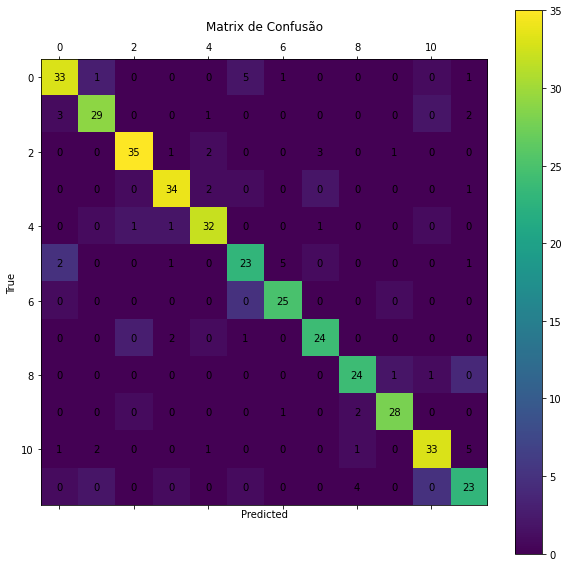

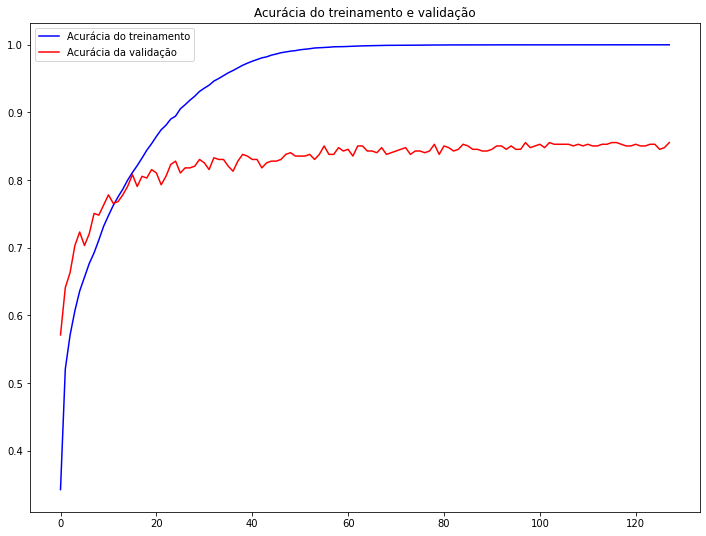

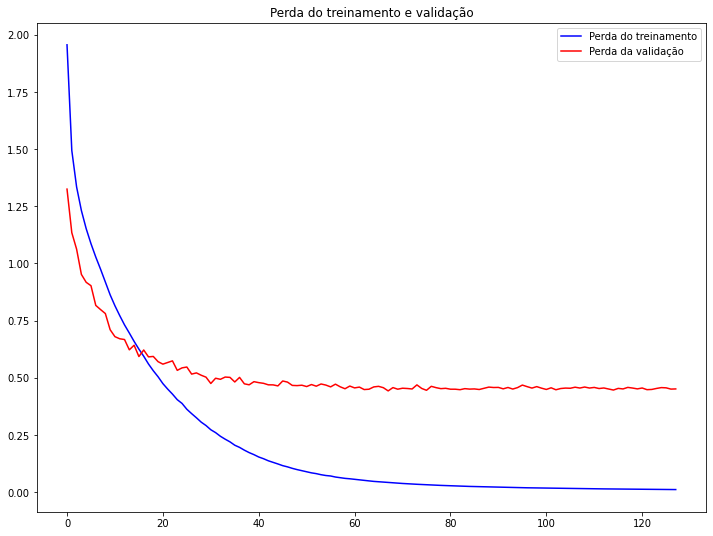

Execution Time: 641.703
EXECUÇÃO - DONE


In [8]:
## Star Time
checkpoint_time = get_time()

## Definitions
NUM_CLASSES = 12
IMG_ROWS = 64
IMG_COLS = 64
EPOCHS = 128

## Loading Inital Data
(x_train, y_train), (x_test, y_test) = load_dataset(TRAIN_FINAL, TEST_FILE, resize=True, convert=True, size=(IMG_ROWS, IMG_COLS))

## Normalize images
x_train = normalize_images(x_train)
x_test = normalize_images(x_test)

## Generating Labels for Confusion Matrix
labels = generate_labels(x_test, y_test)

## Convert class vectros to binary class matrices
y_train = convert_vector(y_train, NUM_CLASSES)
y_test = convert_vector(y_test, NUM_CLASSES)

## Get LeNet 5 Model
model = lenet5(IMG_ROWS, IMG_COLS, NUM_CLASSES)

## Printing Summary
model.summary()

## Compiling Model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=["accuracy"])

## Trainning model
history = fit_model(model, x_train, y_train, x_test, y_test, EPOCHS)

## Getting Score
score = model.evaluate(x_test, y_test, verbose=0)

## Loss
print('Loss:', score[0])

## Accuracy
print('Accuracy:', score[1])

## Confusion Matrix
cm = get_confusion_matrix(model, x_test, labels)
print(f'Confusion Matrix: \n', cm)
plot_confusion_matrix(cm)

## Graphs
plot_graphs(history)

## Execution Time
print(f'Execution Time: {get_time_diff(checkpoint_time)}')

print('EXECUÇÃO - DONE')

# OUTRO MODELO CNN - COM DATA AUGMENTATION

## EXECUÇÃO

Size: (64, 64)
Loading training set...
Loading testing set...
Resizing images...
(17358, 64, 64, 3)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               7372928   
____________________

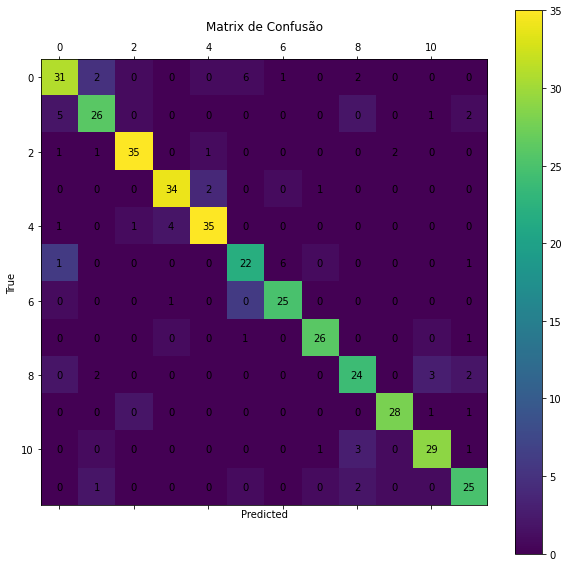

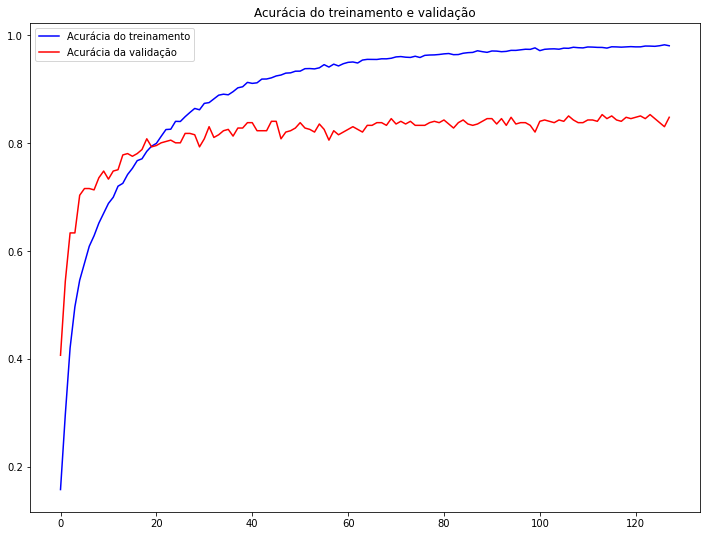

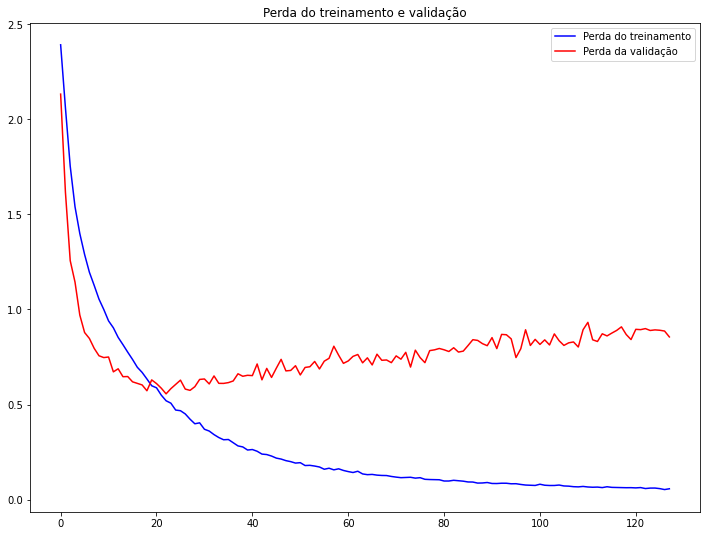

Execution Time: 347.469
EXECUÇÃO - DONE


In [24]:
## Star Time
checkpoint_time = get_time()

## Definitions

NUM_CLASSES = 12
IMG_ROWS = 64
IMG_COLS = 64
EPOCHS = 128

## Loading Inital Data
(x_train, y_train), (x_test, y_test) = load_dataset(TRAIN_FINAL, TEST_FILE, resize=True, convert=True, size=(IMG_ROWS, IMG_COLS))

## Normalize images
x_train = normalize_images(x_train)
x_test = normalize_images(x_test)

## Generating Labels for Confusion Matrix
labels = generate_labels(x_test, y_test)

## Convert class vectros to binary class matrices
y_train = convert_vector(y_train, NUM_CLASSES)
y_test = convert_vector(y_test, NUM_CLASSES)

## Get LeNet 5 Model
model = default(IMG_ROWS, IMG_COLS, NUM_CLASSES)

## Printing Summary
model.summary()

## Compiling Model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=["accuracy"])

## Trainning model
history = fit_model(model, x_train, y_train, x_test, y_test, EPOCHS)

## Getting Score
score = model.evaluate(x_test, y_test, verbose=0)

## Loss
print('Loss:', score[0])

## Accuracy
print('Accuracy:', score[1])

## Confusion Matrix
cm = get_confusion_matrix(model, x_test, labels)
print(f'Confusion Matrix: \n', cm)
plot_confusion_matrix(cm)

## Graphs
plot_graphs(history)

## Execution Time
print(f'Execution Time: {get_time_diff(checkpoint_time)}')

print('EXECUÇÃO - DONE')

# EXTRAÇÃO DE CARACTERÍSTICAS

## CRIANDO OS DIRETÓRIOS E ARQUIVOS

In [ ]:
!mkdir ./data/svm
!touch ./data/svm/test.svm
!touch ./data/svm/train.svm

## EXTRAINDO AS CARACTERÍSTICAS

In [ ]:
## Star Time
checkpoint_time = get_time()

INPUT_FILE_TEST = "./data/test.txt"
OUTPUT_FILE_TEST = "./data/svm/test.svm"
INPUT_FILE_TRAIN = TRAIN_FINAL
OUTPUT_FILE_TRAIN = "./data/svm/train.svm"
IMG_ROWS = 100
IMG_COLS = 100
DIR_DATASET = "./data/data/"

# Train
extract_features(INPUT_FILE_TRAIN, OUTPUT_FILE_TRAIN, IMG_ROWS, IMG_COLS, DIR_DATASET)

# Test
extract_features(INPUT_FILE_TEST, OUTPUT_FILE_TEST, IMG_ROWS, IMG_COLS, DIR_DATASET)

## Execution Time
print(f'Execution Time: {get_time_diff(checkpoint_time)}')

print('EXTRAINDO AS CARACTERÍSTICAS - DONE')

A saída de streaming foi truncada nas últimas 5000 linhas.
./data/data/flip/_0_3869.png
./data/data/shift/_0_2323.png
./data/data/shift/_0_1687.png
./data/data/rotation/_0_2869.png
./data/data/rotation/_0_7456.png
./data/data/rotation/_0_1053.png
./data/data/rotation/_0_3214.png
./data/data/brightness/_0_930.png
./data/data/brightness/_0_5687.png
./data/data/brightness/_0_3917.png
./data/data/brightness/_0_8355.png
./data/data/zoom/_0_1336.png
./data/data/zoom/_0_6482.png
./data/data/zoom/_0_3172.png
./data/data/zoom/_0_6505.png
./data/data/zoom/_0_8902.png
./data/data/zoom/_0_8930.png
./data/data/zoom/_0_3875.png
./data/data/zoom/_0_1163.png
./data/data/zoom/_0_1084.png
./data/data/zoom/_0_6941.png
./data/data/zoom/_0_6965.png
./data/data/zoom/_0_5680.png
./data/data/flip/_0_7745.png
./data/data/flip/_0_4788.png
./data/data/flip/_0_6519.png
./data/data/flip/_0_1411.png
./data/data/shift/_0_8187.png
./data/data/shift/_0_133.png
./data/data/rotation/_0_1933.png
./data/data/rotation/_0_4

# IMPLEMENTANDO O SVM

In [ ]:
## Star Time
checkpoint_time = get_time()

INPUT_TRAIN = "./data/svm/train.svm"
INPUT_TEST = "./data/svm/test.svm"

x_train, y_train = load_svmlight_file(INPUT_TRAIN)
x_test, y_test = load_svmlight_file(INPUT_TEST)

x_train = x_train.toarray()
x_test = x_test.toarray()

classificator = svm.SVC()
classificator.fit(x_train, y_train)
predict = classificator.predict(x_test)
f1_score = round_float(sklearn_f1_score(y_test, predict, labels=np.unique(predict), average='weighted'))
accuracy = round_float(accuracy_score(y_test, predict))
cm = confusion_matrix(y_test, predict)

print(f'Accuracy:  {accuracy}')
print(f'F1Score:  {f1_score}')

## Confusion Matrix
cm = get_confusion_matrix(model, x_test, labels)
print(f'Confusion Matrix: \n', cm)
plot_confusion_matrix(cm)

## Execution Time
print(f'Execution Time: {get_time_diff(checkpoint_time)}')

print('IMPLEMENTANDO O SVM - DONE')